<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Singapore Housing Data and Kaggle Challenge

## Problem Statement

When it comes to property prices in Singapore, the on-ground sentiments we often hear are — "so expensive", "so far", "is it worth the price?"

Yet, there still seems to be a preference amongst some to stay in the central region due to convenience and general accessibility. In our study, we examine how the price of resale HDB flats, particularly in the central region, are influenced by various factors like floor area, age of HDB flat, maximum floor level, proximity to amenities and public transport connectivity.

Ultimately, we aim to address the following question: **"Are resale prices of central region HDBs influenced primarily by its location?"**

In doing so, we hope to empower our target audience to make more calculated and informed decisions on housing whether it's young couples buying their first flats, or older families looking to sell their flats

## Importing Libraries

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-pastel')
pd.set_option('display.max_rows', 200)

## Import EDA and Visualised Datasets

In [124]:
train_edavis = pd.read_csv('datasets/train_edavis.csv')
test_edavis = pd.read_csv('datasets/test_edavis.csv')

## Feature Filtration

Here, we explain the reasons to which we drop the following features before we create the models:

|Dropped Feature|Justification|
|---|---|
|tranc_yearmonth, tranc_year, tranc_month|Datetime, it is not suitable to be used for modelling|
|lease_commence_date, year_completed|Redundant columns, can be represented as `hdb_age`|
|block, street_name, address, postal_code|Redundant for modelling, this model is based on planning area| 
|full_flat_type|combination of `flat_type` and `flat_model`
|storey_range, upper, mid, lower|Represented by mid_storey|
|floor_area_sqm|Same as `floor_area_sqft`|
|price_per_sqft|price should not be used to predict resale_price|
|residential|all column values is 1, no correlation identified|
|commercial|Irrelevant to modelling|
|total_dwelling_units|total units in a HDB, the model will use more detailed breakdown of quantity of 1 room, 2 room, 3 room, etc|
|1room_rental, 2room_rental, 3room_rental, other_room_rental|Irrelevant to predict resale_price|
|hawker_nearest_dist, hawker_within_500m, hawker_within_1km|analysis will focus on quantity of hawker within 2km, this covers for hawker within 500m and 1km|
|all latitude, longitude|Can be represented with nearest distance|
|mrt_name, bus_stop_name|Irrelevant to be modelled in this project|
|all mall columns|based on domain knowledge, malls should not have impact HDB price|
|market_hawker, multistorey_carpark, precint_pavilion, bus_interchange, mrt_interchange, bus_stop_nearest_distance, vacancy|has very minimum correlation to `resale_price`|

## Data Pre-Processing

The data pre-processing will be relevant to our study, and assist in our analyses of data and thereafter modellling. The pre-processing will be done to categorical variables on 3 fronts:
* Converting pri_sec_sch and sec_sch names and Binarising to top_sec_sch and top_pri_sch
* Binarise planning_area (Central vs. Non-Central regions)
* Binarise town (Mature vs. Non-Mature)

#### Convert categorical values `pri_sch_name` and `sec_sch_name` to numerical values. We binarise the top 10 schools and others (those that are not in the top 10) as follows:
* Top schools = 1
* Others schools = 0

The definition of the Top Schools are based on the following sources:
* [`2022 Primary School Ranking`](https://schoolbell.sg/primary-school-ranking/)
* [`2022 Secondary School Ranking`](https://schoolbell.sg/secondary-school-ranking/)

In [125]:
# create top school list for primary school and secondary school
top_pri_sch = ['Rosyth School','Nan Hua Primary School',"Saint Hilda's Primary School",
               'Catholic High School','Henry Park Primary School','Nanyang Primary School',
               'Tao Nan School',"Raffles Girls' School"]

top_sec_sch = ["Raffles Girls' School", 'Raffles Institution',"CHIJ Saint Nicholas Girls' School",
               'Anglo-Chinese School',"Methodist Girls' School",'Dunman High School','Catholic High School',
               "Cedar Girls' Secondary School",'Temasek Junior College','River Valley High School']

# convert school name to numerical value based on top school or not
# convert train datasets 
train_edavis['pri_sch_name'] = train_edavis['pri_sch_name'].apply(lambda x: 1 if x in top_pri_sch else 0)
train_edavis['sec_sch_name'] = train_edavis['sec_sch_name'].apply(lambda x: 1 if x in top_sec_sch else 0)

# convert test datasets
test_edavis['pri_sch_name'] = test_edavis['pri_sch_name'].apply(lambda x: 1 if x in top_pri_sch else 0)
test_edavis['sec_sch_name'] = test_edavis['sec_sch_name'].apply(lambda x: 1 if x in top_sec_sch else 0)

#### Create new column to binarise `planning_area`:
* Central Region (cr) = 1
* Non-Central Region (ncr) = 0

Source: [`Definition of CCR, RCR and NCR`](https://www.propertyguru.com.sg/property-guides/ccr-ocr-rcr-region-singapore-ura-map-21045). This article explains the distribution of each `planning_area` based on the region

Note: From the source there are distrubition of 3 areas which area CCR(Central), RCR (Rest of Central Region) and OCR. For this project, CCR and RCR are combined as one, and defined as `Central Region` . While, anything outside of `Central Region` would be considered as `Non-Central Region`

In [126]:
#create list of central region 
cr = ['Bukit Timah','Downtown Core','Novena','Tanglin','Bishan',
      'Geylang','Kallang','Marine Parade','Outram','Queenstown',
      'Rochor','Toa Payoh', 'Bukit Merah']

#create list of non-central region
ncr = ['Ang Mo Kio', 'Bedok','Bukit Batok','Bukit Panjang', 'Changi', 'Choa Chu Kang',
       'Clementi','Hougang','Jurong East','Jurong West','Pasir Ris','Punggol','Sembawang',
       'Sengkang','Serangoon','Tampines','Western Water Catchment','Woodlands','Yishun']

#create empty list of region
region_train = []
for place in train_edavis['planning_area']:
    if place in cr:
        region_train.append(1)
    else:
        region_train.append(0)

#convert from list to dataframe
region_train = pd.DataFrame(region_train, columns = ['region'])

#combine to train datasets 
train_clean = pd.concat([train_edavis,region_train], axis=1)

#create region dataset for test model
region_test = []
for place in test_edavis['planning_area']:
    if place in cr:
        region_test.append(1)
    else:
        region_test.append(0)

#convert from list to dataframe
region_test = pd.DataFrame(region_test, columns = ['region'])

#combine to test datasets 
test_edavis = pd.concat([test_edavis,region_test], axis=1)

In [127]:
train_edavis['region'] = train_edavis['region'].apply(lambda x: 1 if x == 'Central Region' else 0)

# Display the first few rows to verify the transformation
print(train_edavis.head())

       id             town  flat_type storey_range  flat_model  resale_price  \
0   88471  KALLANG/WHAMPOA     4 ROOM     10 TO 12     Model A      680000.0   
1  122598           BISHAN     5 ROOM     07 TO 09    Improved      665000.0   
2  170897      BUKIT BATOK  EXECUTIVE     13 TO 15   Apartment      838000.0   
3   86070           BISHAN     4 ROOM     01 TO 05     Model A      550000.0   
4  153632           YISHUN     4 ROOM     01 TO 03  Simplified      298000.0   

   tranc_year  mid_storey  lower  upper  ...  bus_stop_nearest_distance  \
0        2016          11     10     12  ...                  29.427395   
1        2012           8      7      9  ...                  58.207761   
2        2013          14     13     15  ...                 214.747860   
3        2012           3      1      5  ...                  43.396521   
4        2017           2      1      3  ...                 129.422752   

   pri_sch_nearest_distance  pri_sch_name  vacancy  sec_sch_nearest_

#### Convert `town` from categorical to numerical value by:

* Mature Estate = 1
* Non-Mature Estate = 0 

Source: [`Non-Mature and Mature Estates`](https://www.propertyguru.com.sg/property-guides/non-mature-vs-mature-bto-55760). This article explains the distribution of `town` based on mature and non-mature estate

In [128]:
# create mature estate list 
mature_estate_list = ['ANG MO KIO','BEDOK','BISHAN','BUKIT MERAH',
                      'BUKIT TIMAH','CENTRAL AREA','CLEMENTI',
                      'GEYLANG','KALLANG/WHAMPOA','MARINE PARADE',
                      'PASIR RIS','QUEENSTOWN','SERANGOON',
                      'TAMPINES','TOA PAYOH']

# train model
train_edavis['town'] = train_edavis['town'].apply(lambda x: 1 if x in mature_estate_list else 0)

# test model
test_edavis['town'] = test_edavis['town'].apply(lambda x: 1 if x in mature_estate_list else 0)

### **Model Creation**

Based on the domain knowledge and correlation coefficient, below is the list of numerical features selected:

**Selected Features**

|Feature|Type|Remarks                             
|---|---|---|
|town|*integer*|Featured to: Mature estate = 1, non-mature estate = 0|
|floor_area_sqft|*float*|No changes from original dataset|
|hdb_age|*integer*|No changes from original dataset|
|max_floor_lvl|*integer*|No changes from original dataset|
|mid_storey|*integer*|No changes from original dataset|
|1room_sold|*integer*|No changes from original dataset|
|2room_sold|*integer*|No changes from original dataset|
|3room_sold|*integer*|No changes from original dataset|
|4room_sold|*integer*|No changes from original dataset|
|5room_sold|*integer*|No changes from original dataset|
|exec_sold|*integer*|No changes from original dataset|
|multigen_sold|*integer*|No changes from original dataset|
|studio_apartment_sold|*integer*|No changes from original dataset|
|cutoff_point|*integer*|No changes from original dataset|
|affiliation|*integer*|No changes from original dataset|
|sec_sch_name|*integer*|Featured to: Top secondary school = 1, other secondary school = 0|
|pri_sch_name|*integer*|Featured to: Top primary school = 1, other primary school = 0|
|mrt_nearest_distance|*float*|No changes from original dataset|
|pri_sch_nearest_distance|*float*|No changes from original dataset|
|sec_sch_nearest_dist|*float*|No changes from original dataset|
|hawker_within_2km|*float*|No changes from original dataset|
|region|*integer*|added feature to represent: Central Region = 1, Outside Central Region = 0|
|planning_area|*str*|No changes from original dataset|
|flat_type|*str*|No changes from original dataset|
|flat_model|*str*|No changes from original dataset|

#### Features Selection

In [129]:
#Numerical Features selected for modelling
features = ['town','floor_area_sqft','hdb_age','max_floor_lvl','mid_storey',
            '1room_sold','2room_sold','3room_sold','4room_sold','5room_sold',
            'exec_sold','multigen_sold','studio_apartment_sold','cutoff_point',
            'affiliation','sec_sch_name','pri_sch_name','mrt_nearest_distance',
            'pri_sch_nearest_distance','sec_sch_nearest_dist','hawker_within_2km', 'region'
            ]

#### Dummifying Variables

In [130]:
#dummify planning area
planning_area_dummies = pd.get_dummies(train_edavis['planning_area'], drop_first = True, dtype = int)

#dummify flat type
flat_model_dummies = pd.get_dummies(train_edavis['flat_type'], drop_first = True, dtype = int)

#dummify flat model
flat_type_dummies = pd.get_dummies(train_edavis['flat_model'], drop_first = True, dtype = int)

#### Model Prepping: Linear Regression

Defining the 'X' and 'Y' variables for Regression

In [131]:
#identifying the dataset for modeling
x_df = pd.concat([train_edavis[features],planning_area_dummies,flat_model_dummies,flat_type_dummies], axis = 1)

#defining the X and Y variables
X = x_df
y = train_edavis['resale_price']

Create Train and Split Model

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

Scale 'X' Variable (using StandardScaler)

*Because there is a significant value differences between some features, for example `floor_area_sqft` and `hdb_age`*

In [133]:
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

Instantiating Model

In [134]:
# Linear Regression
lr = LinearRegression()

In [135]:
# Lasso Regression
lasso = LassoCV(n_alphas=100)

In [136]:
# Ridge Regression
ridge = RidgeCV(np.linspace(0.1,5,100), cv=5)

Fitting the Model

In [137]:
lr.fit(X_train_ss,y_train)
y_preds = lr.predict(X_train_ss)

Cross-Validation Scoring

In [138]:
# check cross_val_score generated 
print(f'Linear Regression cross_val_score on train : {cross_val_score(lr, X_train_ss, y_train, cv=5).mean()}')
print(f'Linear Regression cross_val_score on test: {cross_val_score(lr, X_test_ss, y_test, cv=5).mean()}')

Linear Regression cross_val_score on train : 0.8733296587286385
Linear Regression cross_val_score on test: -1.2246670569359968e+22


**The above Cross-validation score between the train and test model denotes significant difference, hence model is overfitted.**

Determining the R^2 and Errors

In [139]:
print(f"The model r_square value is: {metrics.r2_score(y_train,y_preds)}")
print(f"The model mean absolute percentage error is: {metrics.mean_absolute_percentage_error(y_train,y_preds)}")
print(f"The model mean squared error is: {metrics.mean_squared_error(y_train,y_preds)}")

The model r_square value is: 0.8735629798020578
The model mean absolute percentage error is: 0.09404961888698184
The model mean squared error is: 2589469207.480177


Visual Plotting Linear Regression Model 

                 Column_Name  Coefficient_Value
0                       town       6.786277e+04
1            floor_area_sqft       8.044585e+04
2                    hdb_age      -4.083014e+04
3              max_floor_lvl       2.362318e+04
4                 mid_storey       1.862343e+04
5                 1room_sold       6.446746e+14
6                 2room_sold      -3.575483e+03
7                 3room_sold      -8.872845e+03
8                 4room_sold      -4.605744e+03
9                 5room_sold      -7.784835e+03
10                 exec_sold      -6.913085e+03
11             multigen_sold      -3.067824e+01
12     studio_apartment_sold      -8.106016e+02
13              cutoff_point      -1.302061e+03
14               affiliation      -1.069330e+16
15              sec_sch_name       1.069330e+16
16              pri_sch_name      -2.987181e+03
17      mrt_nearest_distance      -2.522086e+04
18  pri_sch_nearest_distance       2.642802e+03
19      sec_sch_nearest_dist       4.354

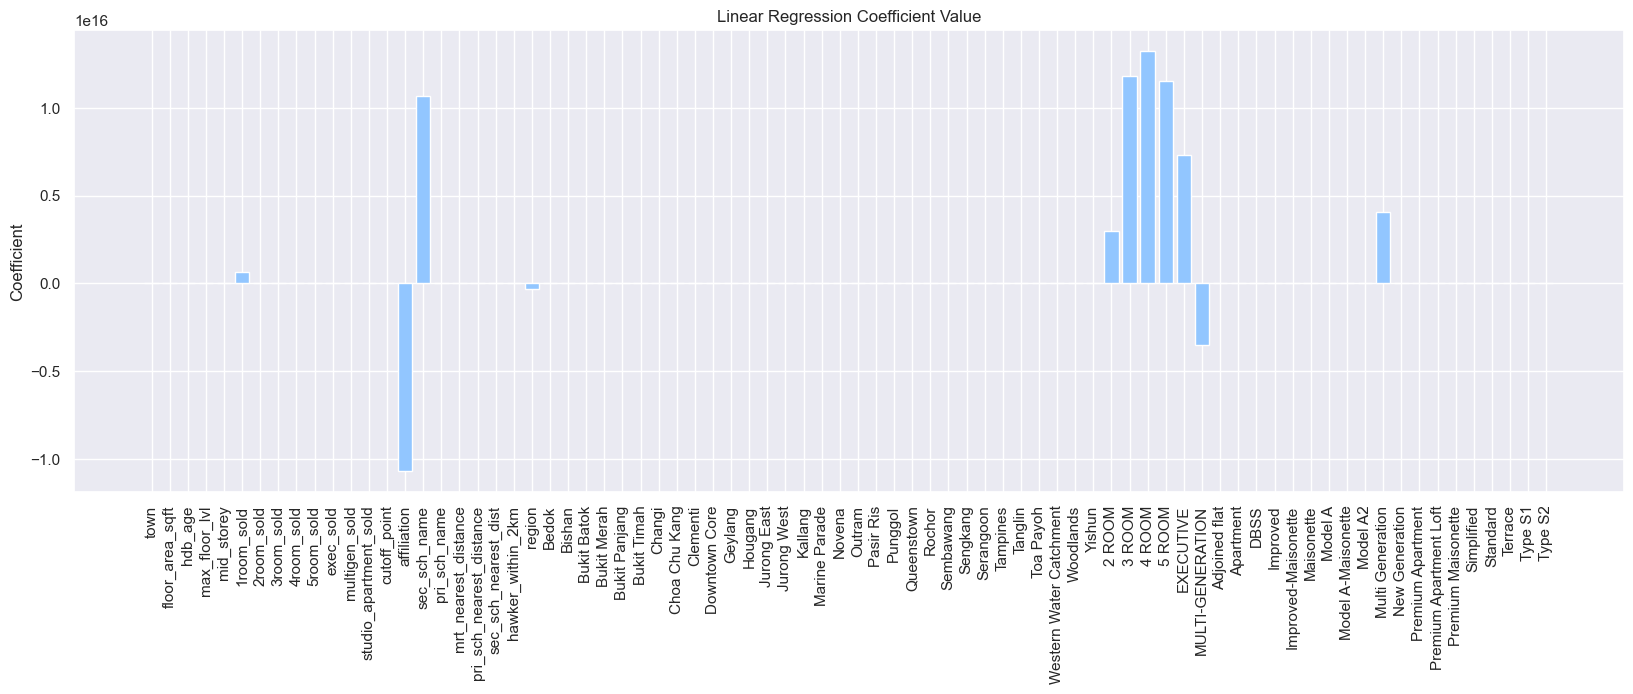

In [140]:
# Create df for storing coefficients and their corresponding variable names
coefficient_df = pd.DataFrame()

# Storing all the column names of predictors
coefficient_df['Column_Name'] = X_train.columns

# Store coefficients of predictors
coefficient_df['Coefficient_Value'] = pd.Series(lr.coef_)

# Preview variables' coefficient values
# The higher the values, the stronger the variables
print(coefficient_df)

# Plot the coefficent values
# Goal is to tune the model so that we get a more stable model i.e. similar size coefficient values
plt.rcParams['figure.figsize'] = (20,6);
plt.bar(coefficient_df["Column_Name"], coefficient_df['Coefficient_Value']);
plt.xticks(rotation= 90);
plt.ylabel('Coefficient')
plt.title('Linear Regression Coefficient Value');
sns.set_theme()

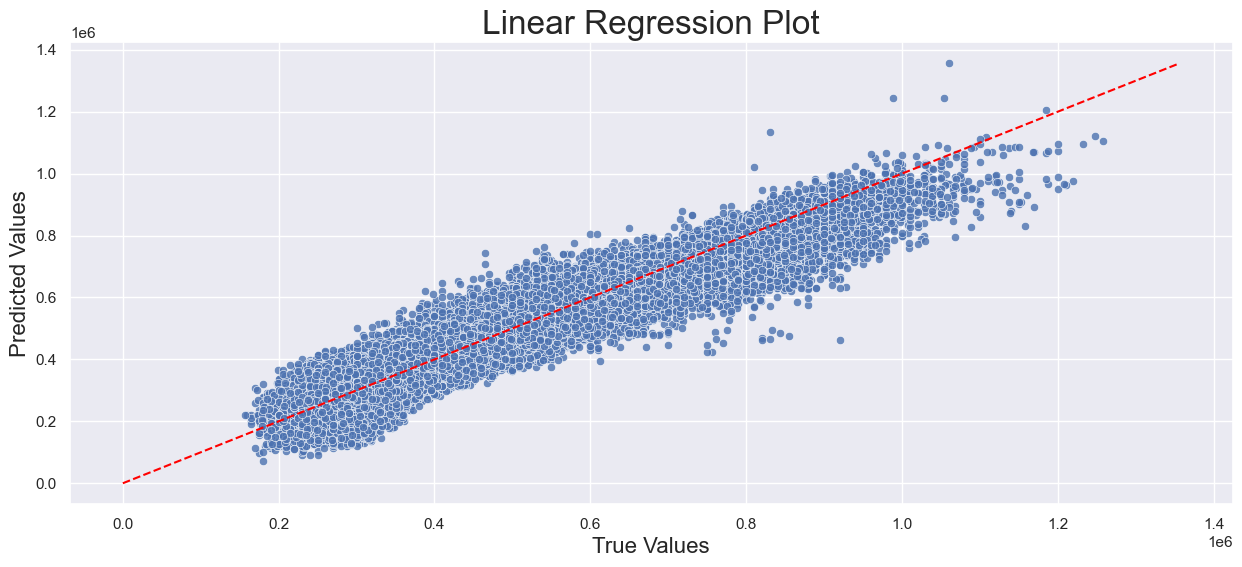

In [141]:
#plot linear regression model 
plt.figure(figsize=(15,6))
sns.set_theme()
sns.scatterplot(x = y_train, y = y_preds, alpha = 0.8)
plt.ylabel("Actual Resale Price")
plt.xlabel("Predicted Resale Price")
plt.title("Linear Regression Model");

#create perfect regression line reference
plt.plot([0, max(max(y_test),max(y_preds))],
         [0, max(max(y_test),max(y_preds))],
         linestyle = '--', color = 'red')

plt.title('Linear Regression Plot', fontsize = 24)
plt.xlabel('True Values', fontsize = 16)
plt.ylabel('Predicted Values', fontsize = 16);

#### Ridge Regression

Instantiating Model

In [142]:
ridge = RidgeCV(np.linspace(1,5,100))

Fitting the Model

In [143]:
ridge.fit(X_train_ss,y_train)

RidgeCV(alphas=array([1.        , 1.04040404, 1.08080808, 1.12121212, 1.16161616,
       1.2020202 , 1.24242424, 1.28282828, 1.32323232, 1.36363636,
       1.4040404 , 1.44444444, 1.48484848, 1.52525253, 1.56565657,
       1.60606061, 1.64646465, 1.68686869, 1.72727273, 1.76767677,
       1.80808081, 1.84848485, 1.88888889, 1.92929293, 1.96969697,
       2.01010101, 2.05050505, 2.09090909, 2.13131313, 2.17171717,
       2.212121...
       3.62626263, 3.66666667, 3.70707071, 3.74747475, 3.78787879,
       3.82828283, 3.86868687, 3.90909091, 3.94949495, 3.98989899,
       4.03030303, 4.07070707, 4.11111111, 4.15151515, 4.19191919,
       4.23232323, 4.27272727, 4.31313131, 4.35353535, 4.39393939,
       4.43434343, 4.47474747, 4.51515152, 4.55555556, 4.5959596 ,
       4.63636364, 4.67676768, 4.71717172, 4.75757576, 4.7979798 ,
       4.83838384, 4.87878788, 4.91919192, 4.95959596, 5.        ]))

Cross-Validation Scoring

In [144]:
# check cross_val_score generated 
print(f'Ridge Regression cross_val_score on train : {cross_val_score(ridge, X_train_ss, y_train, cv=5).mean()}')
print(f'Ridge Regression cross_val_score on test: {cross_val_score(ridge, X_test_ss, y_test, cv=5).mean()}')

Ridge Regression cross_val_score on train : 0.8733312667179227
Ridge Regression cross_val_score on test: 0.87205818742769


**The ridge cross-values are similar for both test and train model, hence the Ridge model fits. We'll proceed on to create prediction variables.**

Prediction Variable

In [145]:
ridge_preds = ridge.predict(X_train_ss)

Determining the R^2 and Errors

In [146]:
print(f"The model r_square value is: {metrics.r2_score(y_train,ridge_preds)}")
print(f"The model mean absolute percentage error is: {metrics.mean_absolute_percentage_error(y_train,ridge_preds)}")
print(f"The model mean squared error is: {metrics.mean_squared_error(y_train,ridge_preds)}")

The model r_square value is: 0.8735628550255773
The model mean absolute percentage error is: 0.09404605908106939
The model mean squared error is: 2589471762.9410176


Visual Plotting Ridge Regression Model 

                 Column_Name  Coefficient_Value
0                       town       66412.622051
1            floor_area_sqft       80420.806024
2                    hdb_age      -40825.175835
3              max_floor_lvl       23629.571788
4                 mid_storey       18623.955089
5                 1room_sold       -1453.094521
6                 2room_sold       -3583.711015
7                 3room_sold       -8878.596608
8                 4room_sold       -4609.441310
9                 5room_sold       -7785.320330
10                 exec_sold       -6918.388424
11             multigen_sold         -28.551956
12     studio_apartment_sold        -811.788413
13              cutoff_point       -1306.546550
14               affiliation        2805.847403
15              sec_sch_name        2805.847403
16              pri_sch_name       -2985.956507
17      mrt_nearest_distance      -25221.427239
18  pri_sch_nearest_distance        2635.997156
19      sec_sch_nearest_dist        4354

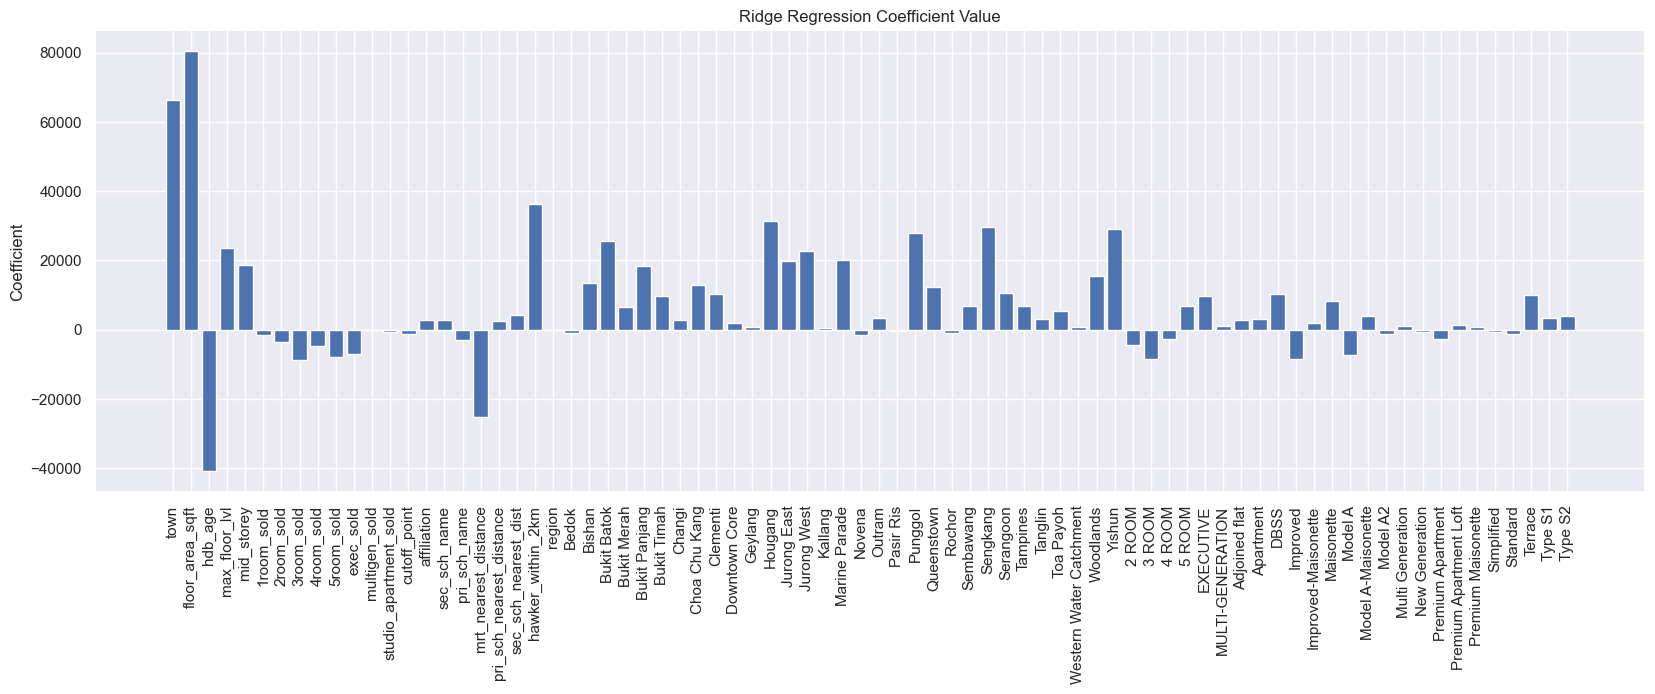

In [147]:
# Create df for storing coefficients and their corresponding variable names
coefficient_df = pd.DataFrame()

# Storing all the column names of predictors
coefficient_df['Column_Name'] = X_train.columns

# Store coefficients of predictors
coefficient_df['Coefficient_Value'] = pd.Series(ridge.coef_)

# Preview variables' coefficient values
# The higher the values, the stronger the variables
print(coefficient_df)

# Plot the coefficent values
# Goal is to tune the model so that we get a more stable model i.e. similar size coefficient values
plt.rcParams['figure.figsize'] = (20,6);
plt.bar(coefficient_df["Column_Name"], coefficient_df['Coefficient_Value']);
plt.xticks(rotation= 90);
plt.ylabel('Coefficient');
plt.title('Ridge Regression Coefficient Value');

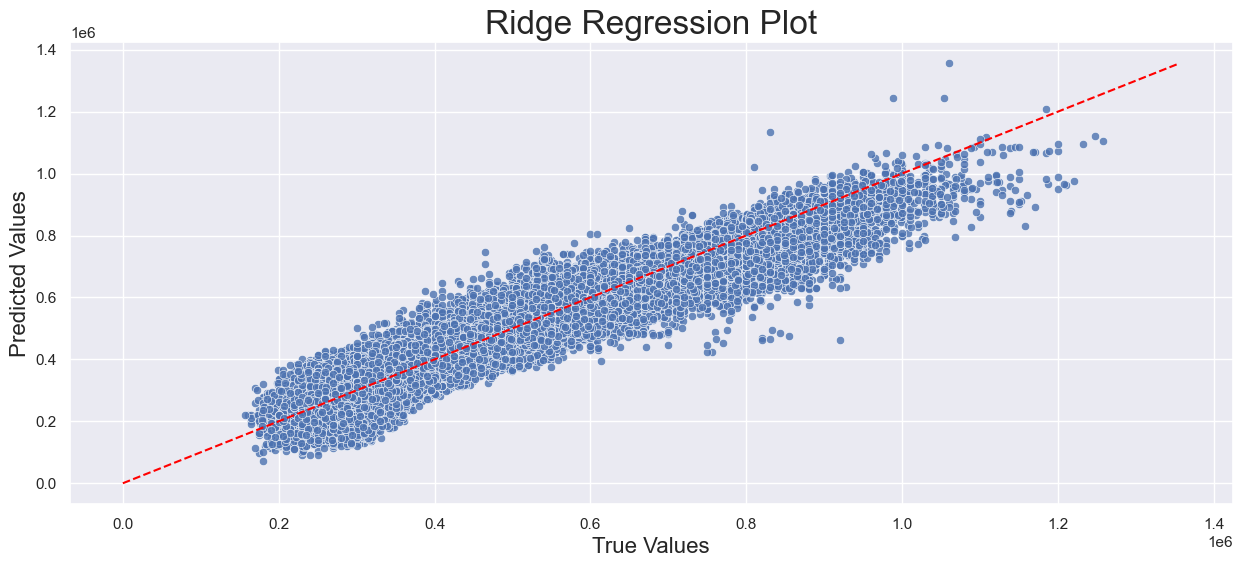

In [148]:
#plot ridge model 
plt.figure(figsize= (15,6))
sns.set_theme()
sns.scatterplot(x = y_train, y = ridge_preds, alpha = 0.8)
plt.ylabel("Actual Resale Price")
plt.xlabel("Predicted Resale Price")
plt.title("Ridge Regression Model");

#create perfect regression line reference
#create perfect regression line reference
plt.plot([0, max(max(y_test),max(ridge_preds))],
         [0, max(max(y_test),max(ridge_preds))],
         linestyle = '--', color = 'red')

plt.title('Ridge Regression Plot', fontsize = 24)
plt.xlabel('True Values', fontsize = 16)
plt.ylabel('Predicted Values', fontsize = 16);

#### Lasso Regression

Instantiating Model

In [149]:
lasso = LassoCV(n_alphas=100)

Fitting the Model

In [150]:
lasso.fit(X_train_ss, y_train)

LassoCV()

Cross-Validation Scoring

In [151]:
# check cross_val_score generated 
print(f'Lasso Regression cross_val_score on train : {cross_val_score(lasso, X_train_ss, y_train, cv=5).mean()}')
print(f'Lasso Regression cross_val_score on test: {cross_val_score(lasso, X_test_ss, y_test, cv=5).mean()}')

Lasso Regression cross_val_score on train : 0.8729512448134529
Lasso Regression cross_val_score on test: 0.8716886757331889


 **The above Lasso regression Model for both train and test are similar. Hence, the model fits.**

Prection Variable

In [152]:
lasso_preds = lasso.predict(X_train_ss)

Determining the R^2 and Errors

In [153]:
print(f"The model r_square value is: {metrics.r2_score(y_train,lasso_preds)}")
print(f"The model mean absolute percentage error is: {metrics.mean_absolute_percentage_error(y_train,lasso_preds)}")
print(f"The model mean squared error is: {metrics.mean_squared_error(y_train,lasso_preds)}")

The model r_square value is: 0.8731769330535567
The model mean absolute percentage error is: 0.09416118942963803
The model mean squared error is: 2597375564.0704093


Visual Plotting Ridge Regression Model 

                 Column_Name  Coefficient_Value
0                       town       1.356406e+04
1            floor_area_sqft       8.181968e+04
2                    hdb_age      -4.080261e+04
3              max_floor_lvl       2.327264e+04
4                 mid_storey       1.858141e+04
5                 1room_sold      -1.118281e+03
6                 2room_sold      -3.501909e+03
7                 3room_sold      -8.553816e+03
8                 4room_sold      -3.840481e+03
9                 5room_sold      -6.997863e+03
10                 exec_sold      -5.559586e+03
11             multigen_sold       0.000000e+00
12     studio_apartment_sold      -6.073277e+02
13              cutoff_point      -1.081504e+03
14               affiliation       5.203357e+03
15              sec_sch_name       6.887213e-10
16              pri_sch_name      -2.594784e+03
17      mrt_nearest_distance      -2.514291e+04
18  pri_sch_nearest_distance       2.638330e+03
19      sec_sch_nearest_dist       4.392

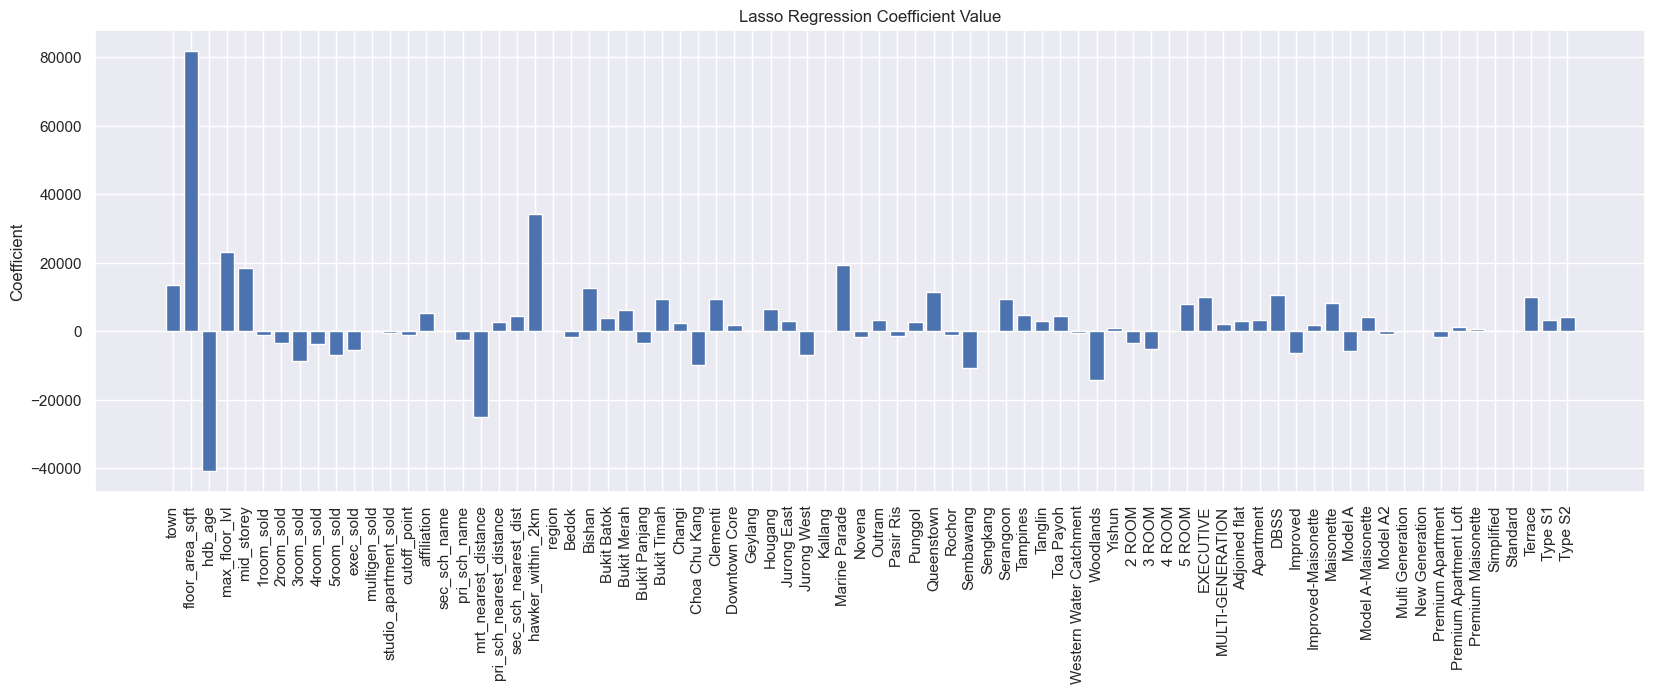

In [154]:
# Create df for storing coefficients and their corresponding variable names
coefficient_df = pd.DataFrame()

# Storing all the column names of predictors
coefficient_df['Column_Name'] = X_train.columns

# Store coefficients of predictors
coefficient_df['Coefficient_Value'] = pd.Series(lasso.coef_)

# Preview variables' coefficient values
# The higher the values, the stronger the variables
print(coefficient_df)

# Plot the coefficent values
# Goal is to tune the model so that we get a more stable model i.e. similar size coefficient values
plt.rcParams['figure.figsize'] = (20,6);
plt.bar(coefficient_df["Column_Name"], coefficient_df['Coefficient_Value']);
plt.xticks(rotation= 90);
plt.ylabel('Coefficient');
plt.title('Lasso Regression Coefficient Value');

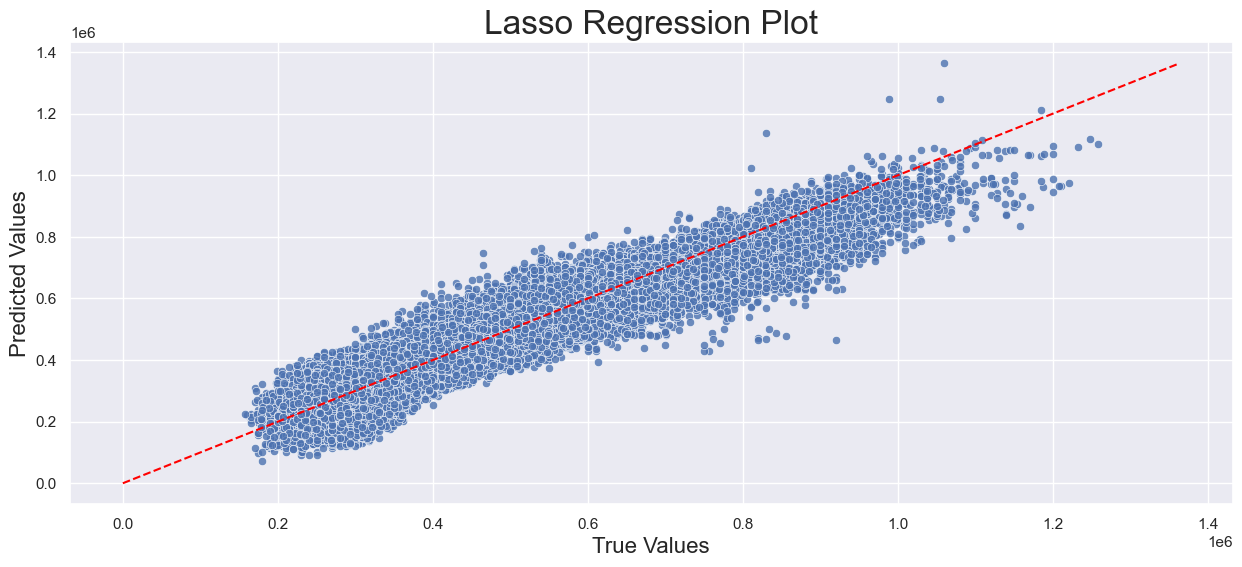

In [155]:
#plot lasso model 
plt.figure(figsize= (15,6))
sns.set_theme()
sns.scatterplot(x = y_train, y = lasso_preds, alpha = 0.8)
plt.ylabel("Actual Resale Price")
plt.xlabel("Predicted Resale Price")
plt.title("Lasso Regression Model");

#create perfect regression line reference
plt.plot([0, max(max(y_test),max(lasso_preds))],
         [0, max(max(y_test),max(lasso_preds))],
         linestyle = '--', color = 'red')

plt.title('Lasso Regression Plot', fontsize = 24)
plt.xlabel('True Values', fontsize = 16)
plt.ylabel('Predicted Values', fontsize = 16);

##### **Insights**

**The Linear Regression model does not fit. And between the Lasso and Ridge Regression models, the Ridge determines a higher Cross-Validation score. Hence, we will abide by the `Ridge` model to predict the test model.**

### Testing Predictive Model with PropertyGuru listings

To be accurate, we will test 2 listings, one from the Central region (Bishan), another from the Non-Central region (Tampines). The listings used are as such:
* Prediction #1: [`Tampines`](https://www.propertyguru.com.sg/listing/hdb-for-sale-317-tampines-street-33-24973777)
* Prediction #2: [`Bishan`](https://www.propertyguru.com.sg/listing/hdb-for-sale-229-bishan-street-23-24964263)


In [156]:
test_edavis['flat_model']

0               Simplified
1        Premium Apartment
2           New Generation
3           New Generation
4                  Model A
               ...        
16732       New Generation
16733    Premium Apartment
16734             Improved
16735           Simplified
16736              Model A
Name: flat_model, Length: 16737, dtype: object

In [157]:
features

['town',
 'floor_area_sqft',
 'hdb_age',
 'max_floor_lvl',
 'mid_storey',
 '1room_sold',
 '2room_sold',
 '3room_sold',
 '4room_sold',
 '5room_sold',
 'exec_sold',
 'multigen_sold',
 'studio_apartment_sold',
 'cutoff_point',
 'affiliation',
 'sec_sch_name',
 'pri_sch_name',
 'mrt_nearest_distance',
 'pri_sch_nearest_distance',
 'sec_sch_nearest_dist',
 'hawker_within_2km',
 'region']

In [158]:
np.unique(test_edavis['flat_model'])

array(['Adjoined flat', 'Apartment', 'DBSS', 'Improved',
       'Improved-Maisonette', 'Maisonette', 'Model A',
       'Model A-Maisonette', 'Model A2', 'Multi Generation',
       'New Generation', 'Premium Apartment', 'Premium Apartment Loft',
       'Premium Maisonette', 'Simplified', 'Standard', 'Terrace',
       'Type S1', 'Type S2'], dtype=object)

##### Prediction #1: Tampines

In [159]:
# creating a dictionary for the Tampines listing
property_dict = {'town' : 1 ,
                'floor_area_sqft': 1152,
                'hdb_age': 29,
                'max_floor_lvl' : 10,
                'mid_storey': 2,
                '1room_sold': 0,
                '2room_sold': 0,
                '3room_sold': 0 ,
                '4room_sold': 45,
                '5room_sold': 45,
                'exec_sold': 0,
                'multigen_sold' : 0 ,
                'studio_apartment_sold' : 0,
                'cutoff_point': 237,
                'affiliation': 0,
                'sec_sch_name': 0,
                'pri_sch_name': 0,
                'mrt_nearest_distance': 410,
                'pri_sch_nearest_distance': 770,
                'sec_sch_nearest_dist': 770,
                'hawker_within_2km': 2,
                'region': 0,
                'planning_area' : 'Tampines',
                'flat_type': '4 ROOM',
                'flat_model': 'New Generation'}

In [160]:
df_property = pd.DataFrame([property_dict])

In [161]:
df_property = pd.get_dummies(df_property, prefix='', prefix_sep='', dtype = int)

In [162]:
missing = []
for name in X.columns:
    if name not in df_property.columns:
        missing.append(name)

df_property[missing] = 0

df_property = df_property[X.columns]

In [163]:
#scale application
X_property = df_property
X_property_ss = ss.transform(X_property)

In [164]:
prop_pred = ridge.predict(X_property_ss)

In [165]:
prop_pred

array([485620.14971727])

##### Prediction #2: Bishan

In [166]:
property_dict2 = {'town' : 1 ,
                'floor_area_sqft': 1097,
                'hdb_age': 32,
                'max_floor_lvl' : 18,
                'mid_storey': 9,
                '1room_sold': 0,
                '2room_sold': 0,
                '3room_sold': 0 ,
                '4room_sold': 108,
                '5room_sold': 10,
                'exec_sold': 0,
                'multigen_sold' : 0 ,
                'studio_apartment_sold' : 0,
                'cutoff_point': 253,
                'affiliation': 1,
                'sec_sch_name': 1,
                'pri_sch_name': 1,
                'mrt_nearest_distance': 810,
                'pri_sch_nearest_distance': 560,
                'sec_sch_nearest_dist': 560,
                'hawker_within_2km': 8,
                'region': 1,
                'planning_area' : 'Bishan',
                'flat_type': '4 ROOM',
                'flat_model': 'Model A'}

In [167]:
df_property2 = pd.DataFrame([property_dict2])

In [168]:
df_property2 = pd.get_dummies(df_property2, prefix='', prefix_sep='', dtype = int)

In [169]:
missing = []
for name in X.columns:
    if name not in df_property2.columns:
        missing.append(name)

df_property2[missing] = 0

df_property2 = df_property2[X.columns]

In [170]:
#scale application
X_property2 = df_property2
X_property2_ss = ss.transform(X_property2)

In [171]:
prop_pred2 = ridge.predict(X_property2_ss)

In [172]:
prop_pred2

array([613785.35678468])

## **Conclusion**

Key Insights: 
- Yes, resale prices of central region HDBs seem to be influenced primarily by its location.
- Secondarily, buyers may be drawn to the generally larger floor areas of central HDBs. However, this may also be found in non-central mature estates.
- Other factors such as proximity to top schools, malls, hawker centres and connectivity via public transport don’t seem to affect resale prices in the central region as much.

Recommendation to Client:
- Client may consider towns that border the central region
    - More budget-friendly (resale price generally below $500k)
    - Towns such as Serangoon and Ang Mo Kio also offer good public transport connectivity
        - Serangoon has a bus and an MRT interchange
        - AMK has a bus interchange, and is one MRT stop away from an MRT interchange (Bishan)

Future Recommendation for Modelling:

|Model Limitation| Possible Solutions|
|---|---|
|Latest transactions in the dataset took place in 2021|Include transactions till 2023 to reflect the latest resale prices|
|Improved infrastructure such as new MRT lines and URA urban planning within certain towns may affect resale prices|Include “developing_towns” as an additional feature in dataset|
|Transaction volume alone may not be a sufficient indicator of supply & demand|Include “time_taken_to_sell” as an additional feature in dataset|

### Kaggle Submission of Predictive Model

In [173]:
test_edavis.head()

,id,town,flat_type,storey_range,flat_model,tranc_year,mid_storey,lower,upper,mid,...,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,pri_sch_name,vacancy,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,region
0,114982,0,4 ROOM,07 TO 09,Simplified,2012,8,7,9,8,...,0,75.683952,426.467910,0,92,156.322353,0,218,0,0
1,95653,0,5 ROOM,04 TO 06,Premium Apartment,2019,5,4,6,5,...,0,88.993058,439.756851,0,45,739.371688,0,199,0,0
2,40303,1,3 ROOM,07 TO 09,New Generation,2013,8,7,9,8,...,0,86.303575,355.882207,0,36,305.071191,0,245,0,0
3,109506,0,4 ROOM,01 TO 03,New Generation,2017,2,1,3,2,...,0,108.459039,929.744711,0,54,433.454591,0,188,0,0
4,100149,0,4 ROOM,16 TO 18,Model A,2016,17,16,18,17,...,0,113.645431,309.926934,0,40,217.295361,0,223,0,0


In [174]:
#dummify planning_area model
test_planning_area_dummy = pd.get_dummies(test_edavis['planning_area'], drop_first=True, dtype= int)

#dummify flat_type
test_flat_type_dummy = pd.get_dummies(test_edavis['flat_type'], drop_first = True, dtype = int)

#dummify flat_model
test_flat_model_dummy = pd.get_dummies(test_edavis['flat_model'], drop_first = True, dtype = int)

In [175]:
x_test_df = pd.concat([test_edavis[features],test_planning_area_dummy,test_flat_type_dummy,test_flat_model_dummy],axis =1)

In [176]:
X.shape

(150634, 78)

In [177]:
x_test_df.shape

(16737, 77)

As the `name` column is missing from the test model, we'll need to add missing column to Kaggle test dataset and re-arrange

In [178]:
#identify missing columns:
missing = []
for name in X.columns:
    if name not in x_test_df:
        missing.append(name)

In [179]:
#add to test dataframe 
x_test_df[missing] = 0

In [180]:
#re-arrange test column based on train test column
x_test_df = x_test_df[X.columns]

Scaling the test features

In [181]:
kaggle_X_test = x_test_df
kaggle_X_test_ss = ss.transform(kaggle_X_test)

Fit the Test Model (Ridge Regression)

In [182]:
kaggle_y_pred = ridge.predict(kaggle_X_test_ss)

Create csv file for kaggle submission

In [183]:
#create dataframe for kaggle_y_pred
df_kaggle_y_pred = pd.DataFrame(kaggle_y_pred, columns=['Predicted'] )

In [184]:
#create csv file for kaggle submssion
df_kaggle_csv = pd.concat([test_edavis['id'],df_kaggle_y_pred],axis=1)

In [185]:
#rename Id based on kaggle requirement
df_kaggle_csv = df_kaggle_csv.rename(columns={'id':'Id'})

In [186]:
df_kaggle_csv

,Id,Predicted
0,114982,337320.535102
1,95653,522952.238502
2,40303,344528.849175
3,109506,286539.612963
4,100149,457762.286174
...,...,...
16732,23347,352624.470409
16733,54003,513245.578587
16734,128921,417384.356268
16735,69352,490348.402881


In [187]:
# Exporting the kaggle file to CSV
df_kaggle_csv.to_csv('kaggle/kaggle-submission.csv', index = False)

#### Proof of Submission

![Kaggle Submission](kaggle/group-kaggle-submission.png)